# Classification de textes Francais par entreprise

# Recuperation de données avec label

In [2]:
# imports
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
from copy import deepcopy
import ast
from scipy import stats
import re
import matplotlib.pyplot as plt

In [3]:
# fetching data
PATH = "./data/ArticleCompany_2020-11-17/"
coprus = "corpus_check_long_SIREN_UPDATED2"
names = "siren_name_map_clean"

with open(PATH + names +".json") as json_file: 
    dict_names = json.load(json_file) 

with open(PATH + coprus +".json") as json_file: 
    corpus_list = json.load(json_file) 

In [4]:
# Convert labels from string to list
print ("The siren list is:",type(corpus_list[0]["siren"]))
for document in corpus_list:
    document["siren"] = ast.literal_eval(document["siren"]) # convert list in string format to list
    for i in range(len(document["siren"])): # Convert each int siren to string 
        document["siren"][i] = str(document["siren"][i])
print ("NOW the type of the siren list is:",type(corpus_list[0]["siren"]))

The siren list is: <class 'str'>
NOW the type of the siren list is: <class 'list'>


# Enlever les articles vides

In [5]:
corpus_list_inter = list()
for i in range(len(corpus_list)):
    if len(corpus_list[i]["corpus"])<100: # small enough
        text = corpus_list[i]["corpus"]
        text = re.sub("^(\s+)", '', text)
        if (len(text)>0):
            corpus_list_inter.append(corpus_list[i])
        else:
            print ("Index of removed article:",i,corpus_list[i]["corpus"])
    else:
        corpus_list_inter.append(corpus_list[i])
corpus_list = corpus_list_inter

Index of removed article: 29805   
Index of removed article: 30158     


In [6]:
print ("There are", len(corpus_list), "articles in the corpus")
print ("There are", len(dict_names), "companies in the list")

There are 57538 articles in the corpus
There are 30178 companies in the list


## Compter Nombre d'Entreprises sans Articles

In [10]:
dict_count = dict()
#for company in dict_names.keys(): dict_count[company] = 0
for document in corpus_list:
    sir_list = document["siren"]
    for siren in sir_list:
        if len(siren)>10 or len(siren)<4 : # Should not be triggered
            print ("ALERT:",siren)
        if siren in dict_count.keys():
            dict_count[siren] +=1
        else:
            dict_count[siren] = 1
print ("There are",len(dict_count.keys()),"companies with articles out of the", len(dict_names.keys()), "companies")
print ("There are",len(dict_names.keys())-len(dict_count.keys()),"companies with no articles")
print (round(len(dict_count)/(len(dict_names))*100,2),"% of the companies have at least one article")
print ("Each article of the corpus has:",corpus_list[0].keys())
#corpus_list[0]["corpus"]

There are 28690 companies with articles out of the 30178 companies
There are 1488 companies with no articles
95.07 % of the companies have at least one article
Each article of the corpus has: dict_keys(['id', 'siren', 'corpus', 'url_article'])


## Trouver les entreprises sans articles

In [8]:
dict_no_acticle_companies = dict()
for company in dict_names.keys():
    if company not in dict_count.keys():
        dict_no_acticle_companies[company] = dict_names[company] 
print (list(dict_no_acticle_companies.keys())[:8])

['512554767', '435404702', '339875817', '797809845', '393239728', '381413947', '433082070', '799911045']


## Etude du nombre d'entreprises associé à chaque Article

DescribeResult(nobs=57538, minmax=(1, 29), mean=1.2476276547672842, variance=0.6042338178020358, skewness=8.133981486117998, kurtosis=136.56851777466036)
There are 48176 arcticles with ONLY ONE label out of the 57538 articles


Text(0.5, 1.0, 'Number of labels per article')

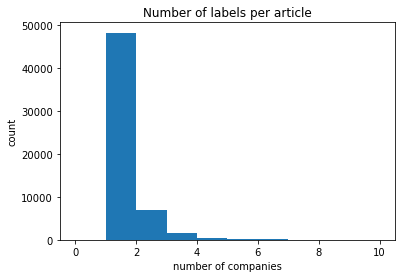

In [11]:
multiple_siren_list = list()
for document in corpus_list:
    if len(document["siren"])==0:
        print ("ALERT article sans label, id:",document["id"])
    multiple_siren_list.append(len(document["siren"]))
    
print(stats.describe(multiple_siren_list))   
print ("There are",multiple_siren_list.count(1),"arcticles with ONLY ONE label out of the",len(corpus_list),"articles") 

plt.hist(multiple_siren_list,range =(0,10), bins=10) #bins=20
plt.xlabel('number of companies')
plt.ylabel('count')
plt.title('Number of labels per article')

## Etudes du nombre d'Articles associé à chaque Entreprise 

DescribeResult(nobs=28690, minmax=(1, 175), mean=2.5021261763680727, variance=28.017371476985655, skewness=11.347634082651822, kurtosis=211.56847613512954)
There are 63.58 % of companies with ONLY ONE associated article
There are 95.14 % of companies with LESS THAN 8 associated articles


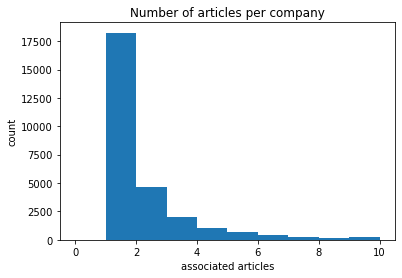

In [16]:
# On prendre seulement les entreprises avec au moins un articles associer

values = list(dict_count.values())
plt.hist(values,range =(0,10), bins=10) #bins=20
plt.xlabel('associated articles')
plt.ylabel('count')
plt.title('Number of articles per company')

number = 8
print(stats.describe(values))
print ("There are",round(values.count(1)/len(values)*100,2), "% of companies with ONLY ONE associated article")
under_n = [1 for i in values if i < number]
print ("There are",round(len(under_n)/len(values)*100,2), "% of companies with LESS THAN",number,"associated articles")

# Tokenize et suppression de stop words du corpus (Méthode 1) 3:30 min

In [17]:
#imports
import nltk
import re
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.corpus import stopwords
stop_words = stopwords.words('french')

In [18]:
print ("Number of stop words",len(stop_words ))
print ("Ex:",stop_words[:5])

Number of stop words 157
Ex: ['au', 'aux', 'avec', 'ce', 'ces']


In [19]:
corpus_cleaned = deepcopy(corpus_list)
for document in tqdm(corpus_cleaned):
    plain_text = document["corpus"]
    plain_text = plain_text.lower()
    plain_text= re.sub(r'\s+', ' ', plain_text)
    #plain_text = re.sub("[^a-z0-9]", ' ', plain_text)
    plain_text = re.sub("[^a-z]", ' ', plain_text)
    plain_text = re.sub(r'\s+', ' ', plain_text)
    #remove one letter words?
    #remove numbers?
    pt_words = word_tokenize(plain_text)
    cleaned_words =list()
    for word in pt_words:
        if len(word)>1:
            if word not in stop_words:
                cleaned_words.append(word)
    document["corpus"] = cleaned_words
# 100%|██████████| 57540/57540 [03:30<00:00, 273.74it/s]

100%|██████████| 57538/57538 [04:39<00:00, 205.92it/s]


# Tokenize en gardant que les Noms (Méthode 2) 20h

In [ ]:
import stanfordnlp # Lemma doesn't work
#stanfordnlp.download('fr')   # This downloads the French models for the neural pipeline
#nlp = stanfordnlp.Pipeline(lang="fr",processors = "tokenize,mwt,lemma,pos") # This sets up a default neural pipeline in French
nlp = stanfordnlp.Pipeline(lang="fr",processors = "tokenize,pos")
#Documentation:
#https://www.analyticsvidhya.com/blog/2019/02/stanfordnlp-nlp-library-python/#

In [ ]:
#Exemple
text = 'Les victoires de Joe Biden à la présidentielle américaine à peine proclamée par les principaux médias américains.'
doc = nlp(text)  
#extract_pos(doc)
for sent in doc.sentences:
    for word in sent.words:
        print(word.text,":", word.upos, word.pos)
doc.sentences[0].words[0] 

In [74]:
len(corpus_nouns)

57538

In [24]:
# load corpus_nouns 
PATH = "./data/ArticleCompany_2020-11-17/"
file = "corpus_nouns"
with open(PATH + file +".json") as json_file: 
    corpus_nouns = json.load(json_file) 

In [25]:
print ("The siren list is:",type(corpus_nouns[0]["siren"]), type(corpus_nouns[0]["corpus"]))

The siren list is: <class 'list'> <class 'list'>


# Extraction d'entreprises avec plus de n articles asocciés

In [20]:
print(list(dict_names.keys())[0:5])
print (dict_names['399258755'])
name_search = "APPLE FRANCE"
for siren, name in dict_names.items():  # for name, age in dictionary.iteritems():  (for Python 2.x)
    if name_search in name:
        print(siren, name)
print("APPLE FRANCE a",dict_count["322120916"],"articles dans le corpus")

['419838529', '813883964', '572060333', '542104245', '399258755']
SPIE OPERATIONS
322120916 APPLE FRANCE
APPLE FRANCE a 7 articles dans le corpus


In [21]:
number = 5 # Number of articles a company must have to be kept in the list
siren_filtered =[key for key in dict_count if dict_count[key] > number]
print ("There are",len(siren_filtered),"companies with MORE than",number,"associated articles out of the",len(dict_names.keys()),"initial companies")

There are 2084 companies with MORE than 5 associated articles out of the 30178 initial companies


# Creation de Train et Test set pour l'entrainement de Tf.Idf

In [73]:
from sklearn.model_selection import train_test_split
import random

In [87]:
# Remove all of the articles that dont talk about our selected companies (in siren filtered)
# Split corpus train/test
#corpus = corpus_cleaned
corpus = corpus_nouns
test_size = 0.3
X_train_corpus = list()
X_test_corpus = list()

#Removing unwanted articles
print("Removing unwanted articles")
corpus_temp = list()
for document in corpus:
    keep = False
    for document_sirens in document["siren"]:
        for sirens in siren_filtered:
            if document_sirens == sirens:
                keep = True
    if keep:
        corpus_temp.append(document)
print ("We removed:",len(corpus)-len(corpus_temp),"articles and we have",len(corpus_temp),"left")
corpus = corpus_temp
 
#Splitting data
print("Splitting data") 
#for document in corpus:
#    if (random.uniform(0, 1)<test_size):
#        X_test_corpus.append(document)
#    else:
#        X_train_corpus.append(document)
X_train_corpus, X_test_corpus = train_test_split(corpus, test_size=test_size, random_state=0)

print ("We have",len(X_train_corpus),"documents in the training corpus")
print ("We have",len(X_test_corpus),"documents in the testing corpus")

Removing unwanted articles
We removed: 29189 articles and we have 28349 left
Splitting data
We have 19844 documents in the training corpus
We have 8505 documents in the testing corpus


# Tf.Idf pour une liste d'entreprise sur le training data (1h20)

In [88]:
# imports
from sklearn.feature_extraction.text import TfidfVectorizer 

In [89]:
# Tf.Idf on Companies that have Associated Articles 

relevant_words_tfidf = {}
corpus = X_train_corpus # corpus

list_siren = siren_filtered

def identity_tokenizer(text):
    return text
for siren in tqdm(list_siren):
    #siren = "322120916" #APPLE FRANCE
    plain_text_list = list()
    company_article = list()
    #binary = True
    #sublinear_tf=False
    tfidf_vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, ngram_range = (1,1), lowercase=False, sublinear_tf=True)
    #tfidf_vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, ngram_range = (1,1), lowercase=False, sublinear_tf=False)
    for document in corpus:
        if siren in document["siren"]:
            company_article = company_article+document["corpus"]  # add article to company BIG article
        else:
            plain_text_list.append(document["corpus"]) # otherwise add to corpus

    plain_text_list.insert(0,company_article) # add company article to begging of corpus
    tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(plain_text_list)

    #Get the tf-idf scores for the words in the company article complication.
    first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[0] # discard tf.idf scores for the other texts

    # place tf-idf values in a pandas data frame 
    df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"]) 
    df = df.sort_values(by=["tfidf"],ascending=False).head(40) # Take top 40 words

    relevant_words_tfidf[siren] = list(zip(list(df.index),list(df["tfidf"])))
    #print (relevant_words_tfidf[company])


#100%|██████████| 2084/2084 [2:28:45<00:00,  4.28s/it] # tokenized tf
#100%|██████████| 2084/2084 [2:03:31<00:00,  3.56s/it] # tokenized binary
#100%|██████████| 2084/2084 [3:06:54<00:00,  5.38s/it]   # tokenized sublinear_tf
#100%|██████████| 2084/2084 [1:21:23<00:00,  2.34s/it] # nouns sublinear_tf


100%|██████████| 2084/2084 [1:55:05<00:00,  3.31s/it]   


In [ ]:
relevant_words_tfidf

In [72]:
# save dictionary
PATH = "./relevant_words/francais/"
file = "relevant_words_tfidf_nouns_sublinear_tf"
a_file = open(PATH + file + ".json", "w")
json.dump(relevant_words_tfidf, a_file)
a_file.close()
print (file,"is saved successfully")

relevant_words_tfidf_tokenize is saved successfully


In [97]:
# load dictionary 
PATH = "./relevant_words/francais/"
file = "relevant_words_tfidf_tokenize_sublinear_tf"
a_file = open(PATH + file + ".json", "r")
relevant_words_tfidf = json.load(a_file)
#relevant_words_tfidf = dict(relevant_words_tfidf)
# check if well loaded
print (file,"is loaded successfully") 

relevant_words_tfidf_tokenize_sublinear_tf is loaded successfully


In [234]:
relevant_words_tfidf[list(relevant_words_tfidf.keys())[0]][:10]

[['ipsen', 0.13919225922627243],
 ['meek', 0.11910951051014622],
 ['onivyde', 0.10173082172319803],
 ['lebeaut', 0.09891742419373598],
 ['merrimack', 0.0896765377510199],
 ['probi', 0.0896765377510199],
 ['medecine', 0.08433141519724636],
 ['somatuline', 0.08382002820896443],
 ['oncologie', 0.07668327571700699],
 ['hennion', 0.07629149171357667]]

In [18]:
#relevant_words_tfidf.keys()
#relevant_words_tfidf['419838529']
#type(relevant_words_tfidf)
#len(relevant_words_tfidf.keys())

# Fetching Relevant Words from ES

In [28]:
# load dictionary 
PATH = "./relevant_words/francais/"
#file = "relevant_words_train"
file = "relevant_words_2"
a_file = open(PATH + file + ".json", "r")
relevant_words_es = json.load(a_file)

# check if well loaded
print (file,"is loaded successfully") 

relevant_words_2 is loaded successfully


In [29]:
# Collect only the relevant words for the sirens that we want to consider
count = 0
for siren in siren_filtered:
    if siren in relevant_words_es.keys():
        count +=1
print ("There are", count, "companies in the ES RWords out of the",len(siren_filtered), "words in the article labels")

There are 0 companies in the ES RWords out of the 2084 words in the article labels


In [30]:
# Removing all the empty significant words and keeping only siren_filtered
relevant_words_es_clean = dict()
for siren in siren_filtered:
    if siren in relevant_words_es.keys():
        if len(relevant_words_es[siren])>0:
            relevant_words_es_clean[siren] = relevant_words_es[siren]
len(relevant_words_es_clean.keys())
print ("There are", len(relevant_words_es_clean.keys()), "non empty companies in ES RWords out of the",len(siren_filtered), "words in the article labels")

There are 0 non empty companies in ES RWords out of the 2084 words in the article labels


# Building baseline model 

In [31]:
#Labeling article if it has the company name in it
relevant_words_baseline = dict()
for key in dict_names.keys():
    #print (key)
    #print([dict_names[key].lower()])
    relevant_words_baseline[key] = [[dict_names[key].lower(),1]]
#relevant_words_baseline

# Text Classifier

In [32]:
# imports
import operator
import string 
import nltk
import re
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.corpus import stopwords
stop_words = stopwords.words('french')

In [310]:
#################################################################
# CLEANING PLAIN TEXT
#Input  : Plain text - String
#Output : Text removing all punctuation and lowercased
#################################################################
def clean_plain_text(text):
    text = text.lower() # lower
    text = text.translate(str.maketrans("","", string.punctuation)) # removing punctuation
    text = re.sub(r'»|«|–|…', '', text)  # suprime guillmets 
    text = re.sub(r'è|é|ê|ë|ē|ė|ę', 'e', text)  # suprime accents sur le e
    text = re.sub(r'à|á|â|ä|æ|ã|å|ā', 'a', text)  # suprime accents sur le a
    text = re.sub(r'\s+', ' ', text) # remove everything else
    text = word_tokenize(text)
    cleaned_text = list()
    for word in text:
        if len(word)>1:
            if word not in stop_words:
                cleaned_text.append(word)
    text = cleaned_text
    return text

In [386]:
#EXAMPLE of clean_plain_text
plain_text = """
Créé en 2008 par deux anciens salariés d’une agence de publicité, Konbini est un site d’infotainement (infodivertissement),
mêlant informations et divertissement. Accessibles gratuitement, ces contenus sont financés par de la publicité apparente
(les fameuses bannières cliquables et parfaitement identifiables) et de la publicité plus discrète, appelée 
publi-rédactionnel et « native advertising ». En raison des systèmes de blocage de publicité, comme Adblocks, 
les sites ont de plus en plus recours à ces publicités discrètes. 
"""
#plain_text = ". ? ! , ; : … ( ) [ ] « » – / {} ..."

#index = 3
#plain_text = corpus_list[index]["corpus"]
#print (dict_names[corpus_list[index]["siren"][0]])
print(plain_text)
plain_text = clean_plain_text(plain_text)
print()
print(plain_text)



Créé en 2008 par deux anciens salariés d’une agence de publicité, Konbini est un site d’infotainement (infodivertissement),
mêlant informations et divertissement. Accessibles gratuitement, ces contenus sont financés par de la publicité apparente
(les fameuses bannières cliquables et parfaitement identifiables) et de la publicité plus discrète, appelée 
publi-rédactionnel et « native advertising ». En raison des systèmes de blocage de publicité, comme Adblocks, 
les sites ont de plus en plus recours à ces publicités discrètes. 


['cree', '2008', 'deux', 'anciens', 'salaries', 'agence', 'publicite', 'konbini', 'site', 'infotainement', 'infodivertissement', 'melant', 'informations', 'divertissement', 'accessibles', 'gratuitement', 'contenus', 'finances', 'publicite', 'apparente', 'fameuses', 'bannieres', 'cliquables', 'parfaitement', 'identifiables', 'publicite', 'plus', 'discrete', 'appelee', 'publiredactionnel', 'native', 'advertising', 'raison', 'systemes', 'blocage', 'publicite', 'c

# Function to compute a "Related Scores" for a company

In [396]:
#################################################################
# Gives a companies "related score" wrt an article (using it's significant words)
#INPUT :plain_text- String/ word_list - list of significant words
#OUTPUT: Score the chances the company is related to the article
#################################################################
def company_relevance_score(plain_text, related_words): 
    epsilon = 0.0001
    sig_words = np.array(related_words)[:,0]
    related_words_score = np.array(related_words)[:,1]
    sum_exp = np.sum([np.exp(float(score)) for score in related_words_score]) # element for computing the soft max
    n_words = len(plain_text)
    
    words_in_text = 0
    for i in range(len(related_words)):
        word_soft_max = np.exp(float(related_words_score[i]))/sum_exp
        words_in_text += word_soft_max*plain_text.count(sig_words[i])
    #print (n_words)
    return words_in_text/n_words+epsilon

In [399]:
# EXAMPLE OF : company_relevance_score
plain_text = """
Créé en 2008 par deux anciens salariés d’une agence de publicité, Konbini est un site d’infotainement (infodivertissement),
mêlant informations et divertissement. Accessibles gratuitement, ces contenus sont financés par de la publicité apparente
(les fameuses bannières cliquables et parfaitement identifiables) et de la publicité plus discrète, appelée 
publi-rédactionnel et « native advertising ». En raison des systèmes de blocage de publicité, comme Adblocks, 
les sites ont de plus en plus recours à ces publicités discrètes. 
"""
plain_text = clean_plain_text(plain_text)
print ("plain_text",plain_text)
n_significant_words = 1
related_words = np.array(relevant_words_tfidf['502220056'])[:n_significant_words] # filter significant words
print (dict_names['502220056'])
print("n_significant_words:",n_significant_words)
print (related_words)
score = company_relevance_score(plain_text, related_words) 
print ("related score         ",score)
t = 250 # Must be fine tune manualy to get the best results in our case a related score of 0,02 is GOOD 
score = 1 - 1/(1 + t*score) 
print ("smoothed related score",score)
# changer le score

plain_text ['cree', '2008', 'deux', 'anciens', 'salaries', 'agence', 'publicite', 'konbini', 'site', 'infotainement', 'infodivertissement', 'melant', 'informations', 'divertissement', 'accessibles', 'gratuitement', 'contenus', 'finances', 'publicite', 'apparente', 'fameuses', 'bannieres', 'cliquables', 'parfaitement', 'identifiables', 'publicite', 'plus', 'discrete', 'appelee', 'publiredactionnel', 'native', 'advertising', 'raison', 'systemes', 'blocage', 'publicite', 'comme', 'adblocks', 'sites', 'plus', 'plus', 'recours', 'publicites', 'discretes']
KONBINI
n_significant_words: 1
[['konbini' '0.1586134258507446']]
related score          0.022827272727272727
smoothed related score 0.8508980006777364


# Function to compute and compare "Related Scores" for each company

In [400]:
#################################################################
# For an Article, gives the "related scores"(likeness of being a label) for all companies
#INPUT :plain_text- String/company related words - dict/ params
#OUTPUT: dict of companies and their "related scores"
#################################################################
def text_label_scores(plain_text,related_words,n_sig_words=10, min_score = 0.5):
    t = 250 # score smoothing facter: 0+: monte doucement vers 1, +inf: monte rapidement vers 1
    label_dict = {}
    #print (sig_words_list)
    for siren in related_words.keys():
        #print(related_words[siren])
        sig_words_list = np.array(related_words[siren])[:n_sig_words] # Build significant word list (with no scores)
        #print ("sig_words_list")
        score = company_relevance_score(plain_text, sig_words_list)
        score = 1 - 1/(1 + t*score) # smooth relevant scores
        #print (score)
        if score>=min_score:
            label_dict[siren]= score
    
    
    # ORDERING OF SELECTED COMPANIES BY SCORE
    ### Soft_max ###
    #sum_exp = sum([np.exp(v) for v in label_dict.values()])
    #label_dict = {k: np.exp(v)/sum_exp for k, v in sorted(label_dict.items(), key=lambda item: -item[1])}
    ### normalizing score ###
    #max_val = max(label_dict.values())
    #label_dict = {k: v/max_val for k, v in sorted(label_dict.items(), key=lambda item: -item[1])}
    ### Plain score ###
    label_dict = {k: v for k, v in sorted(label_dict.items(), key=lambda item: -item[1])}
    return label_dict

### Testing text_label_scores

In [408]:
#EXAMPLE of : text_label_scores
plain_text = """
La victoire de Joe Biden à la présidentielle américaine à peine proclamée par les principaux 
médias américains, les messages de félicitations des dirigeants occidentaux affluent. Sur Twitter,
une courte séquence vidéo fait le buzz entre Londres et Dublin. Ce 7 novembre, on y voit le 
candidat démocrate entouré de journalistes.
"""
plain_text2 = """
Créé en 2008 par deux anciens salariés d’une agence de publicité, Konbini est un site d’infotainement (infodivertissement),
mêlant informations et divertissement. Accessibles gratuitement, ces contenus sont financés par de la publicité apparente
(les fameuses bannières cliquables et parfaitement identifiables) et de la publicité plus discrète, appelée 
publi-rédactionnel et « native advertising ». En raison des systèmes de blocage de publicité, comme Adblocks, 
les sites ont de plus en plus recours à ces publicités discrètes. 
"""
plain_text3 = "Bourse en ligne : Information boursiere, Economie, Finance, Bourse de paris - Cerclefinance"

plain_text = clean_plain_text(plain_text2)
print("plain_text",plain_text)
related_words = relevant_words_tfidf
n_sig_words= 3
min_score = 0.5 # nbr of sig words in text
print ("params:")
print ("n_sig_words:",n_sig_words)
print ("min_score  :",min_score)
#print (plain_text)
label_dict = text_label_scores(plain_text,related_words, n_sig_words, min_score)
print("companies kept",label_dict)

for key in label_dict.keys(): # Should not trigger
    if len(key)>10:
        print (key, "error!")
#find out why label_dict
print ("The predicted companies are:")
for key in label_dict.keys():
    print(key, dict_names[key])

plain_text ['cree', '2008', 'deux', 'anciens', 'salaries', 'agence', 'publicite', 'konbini', 'site', 'infotainement', 'infodivertissement', 'melant', 'informations', 'divertissement', 'accessibles', 'gratuitement', 'contenus', 'finances', 'publicite', 'apparente', 'fameuses', 'bannieres', 'cliquables', 'parfaitement', 'identifiables', 'publicite', 'plus', 'discrete', 'appelee', 'publiredactionnel', 'native', 'advertising', 'raison', 'systemes', 'blocage', 'publicite', 'comme', 'adblocks', 'sites', 'plus', 'plus', 'recours', 'publicites', 'discretes']
params:
n_sig_words: 3
min_score  : 0.5
companies kept {'502220056': 0.6638283156326465, '810875039': 0.6551541848806313, '537450140': 0.6531576847241614}
The predicted companies are:
502220056 KONBINI
810875039 NEXTSTAGE
537450140 INVIBES ADVERTISING


In [365]:
#relevant_words_tfidf['537450140']

# Function predict text labels of plain text

In [402]:
#################################################################
# For an Article, predicts the labels (sirens)
#INPUT : plain_text- String/company related words - dict/ params
#OUTPUT: dict of companies and their "related scores"
#################################################################
def label_text(plain_text,related_words, n_sig_words= 10, min_score = 0.1):
    label_dict = text_label_scores(plain_text,related_words, n_sig_words, min_score)
    #print("best score",label_dict[list(label_dict.keys())[0]])
    sirens = list(label_dict.keys())
    return sirens[:10] # limiting the number of predictions to 8

# Testing accuracy of the model

In [503]:
related_words = relevant_words_tfidf #model related words
#related_words = relevant_words_es_clean #relevant_words_es
#related_words = relevant_words_baseline

#corpus = X_train_corpus[:1000] # pour verifier que on peut sur entrainer
corpus = X_test_corpus[:1000] # pour tester sur de nouveaux articles
min_score = 0.95
n_sig_words = 1

pred_eval = list() # Tag each prediction 1:correct, 0:wrong for each article
pred_labels = list() # Siren predicted for each article
article_eval = list() # Tag each label if 1:predicted, 0:not predicted for each article
article_labels = list() # Siren labels for each article
pred_labels_flat = list() #list all predicted sirens flattened
article_labels_flat = list() # list of all siren labels flattened

for document in tqdm(corpus):
    plain_text = document["corpus"]
    
    #pred_labels
    pred_sirens = label_text(plain_text,related_words, n_sig_words, min_score)
    pred_labels.append(pred_sirens)
    #pred_labels_flat
    pred_labels_flat += pred_sirens
    
    #article_labels
    true_sirens =document["siren"]
    article_labels.append(true_sirens)
    #article_labels_flat
    article_labels_flat +=true_sirens
    
    #pred_eval 
    is_labeled = [0]*len(pred_sirens)
    for i in range(len(pred_sirens)):  # For each predicted company
        for label in true_sirens: # For each labeled company
            if pred_sirens[i]==label:  # Tag if it is a good or bad predictions
                is_labeled[i]=1
    pred_eval.append(is_labeled) 
    
    #article_eval
    is_predicted = [0]*len(true_sirens)
    for i in range(len(true_sirens)):  # For each label list
        for pred in pred_sirens:       # For each prediction on the articel
            if true_sirens[i]==pred:    # Tag the labels that have been predicted
                is_predicted[i]=1
    article_eval.append(is_predicted) 
#100%|██████████| 300/300 [02:23<00:00,  2.08it/s] # avec split train test
#100%|██████████| 300/300 [01:37<00:00,  3.08it/s] # avec random split

100%|██████████| 1000/1000 [06:46<00:00,  2.46it/s]


In [504]:
print ("There are",len(set(pred_labels_flat)),"distinct labels predicted out of the",len(siren_filtered),"total filtered labels")
print ("There are",len(set(article_labels_flat)),"distinct labels TO predicted out of the",len(siren_filtered),"total filtered labels")
#set(article_labels_flat)

There are 106 distinct labels predicted out of the 2084 total filtered labels
There are 986 distinct labels TO predicted out of the 2084 total filtered labels


# EVALUATING MODEL

In [505]:
import matplotlib.pyplot as plt

There are 1000 texts evaluated
Score 1: 0.086 (with at least ONE label predicted)
Score 2: 0.073 (with ALL labels predicted)
Score 3: 0.068 (with ALL labels predicted in the FIRST predictions)
Score 4: 0.664 (Number of correct predictions over total number of predictions overall)
Average number of predictions 0.131 vs average number of labels : 1.33
The siren that is predicted the most is: 542107651 ( 11 times)
######################### For Each company #########################
AVG ACCURACY : 0.063 True_pos/Pos -> average for each siren
AVG PRECISION: 0.083 True_pos/(True_Pos + False_Pos) -> average for each siren
AVG RECALL   : 0.063 True_pos/(True_Pos + False_Neg) -> average for each siren
AVG F1 score : 0.068 combination of precision and recall -> average for each siren
AVG ACCURACY : 0.063
AVG PRECISION: 0.083
AVG RECALL   : 0.063
AVG F1 score : 0.068

######################### For Each article #########################
AVG PRECISION: 0.08 #correct_predictions/#predictions-> avera

Text(0.5, 1.0, 'recall hist (on each article)')

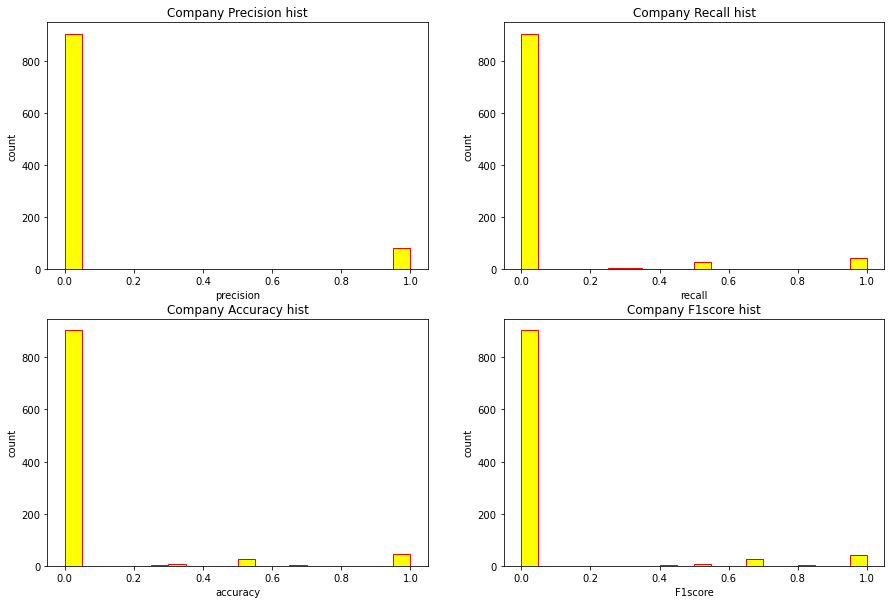

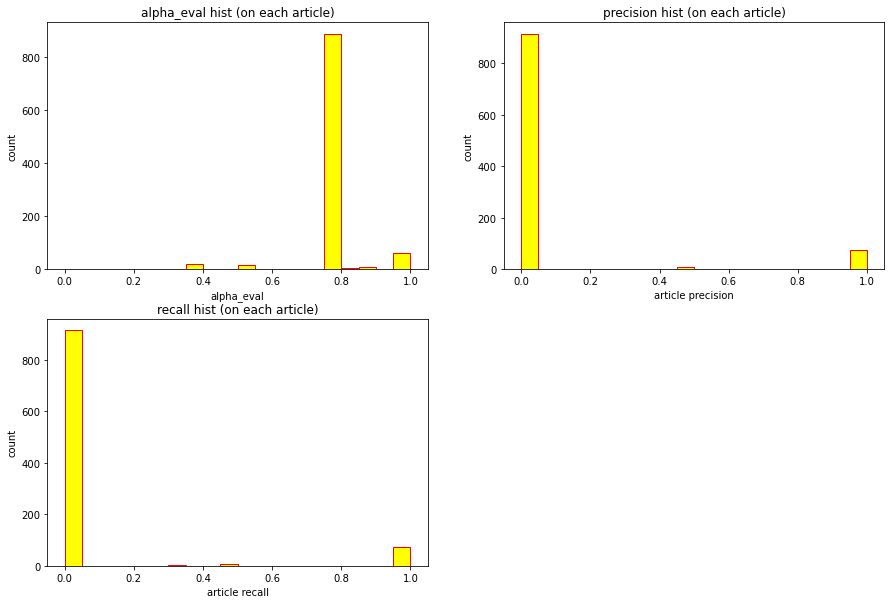

In [506]:
print ("There are",len(pred_eval),"texts evaluated")
########## How many times (at least) one of the companies are predicted ##########
acc1 = list()
for preds in pred_eval:
    acc1.append(any(preds))
print("Score 1:", round(np.sum(acc1)/len(pred_eval),3),"(with at least ONE label predicted)")

########## How many times ALL the labels are present in the prediction. ##########
acc2 = list()
for labels in article_eval:
    acc2.append(labels.count(1)== len (labels)) 
print("Score 2:", round(np.sum(acc2)/len(pred_eval),3),"(with ALL labels predicted)")

########## How many times ALL labels are predicted in the FIRST predictions. ##########
acc3 = list()
for i in range(len(pred_eval)):
    labels = article_eval[i]
    preds = pred_eval[i]
    acc3.append(preds[:len(labels)].count(1)== len(labels))
print("Score 3:", round(np.sum(acc3)/len(pred_eval),3),"(with ALL labels predicted in the FIRST predictions)")

########## How many predictions are wrong wrt. how many are right (TRUE, FALSE) ##########
true_pred = 0
pred = 0
for preds in pred_eval:
    true_pred += np.sum(preds)
    pred += len(preds)
print("Score 4:",round(true_pred/pred,3),"(Number of correct predictions over total number of predictions overall)")

########## Average number of predictions vs average number of labels ##########
len_label = list()
len_pred = list()
for i in range(len(pred_eval)):
    len_label.append(len(corpus[i]["siren"]))
    len_pred.append(len(pred_eval[i]))
print("Average number of predictions",round(np.mean(len_pred),3),"vs average number of labels :", round(np.mean(len_label),2))

########## Most commun labels predicted ##########
count_pred = dict()
for siren in article_labels_flat:
    if siren in count_pred.keys():
        count_pred[siren] +=1
    else:
        count_pred[siren] = 1
key_max = list(filter(lambda t: t[1]==max(count_pred.values()), count_pred.items()))[0][0] 
print("The siren that is predicted the most is:",key_max,"(",np.max(list(count_pred.values())),"times)")

########## Precision & RECALL ########## per siren(Company)
company_accuracy_list = list()
company_precision_list = list()
company_recall_list = list()
company_F1score_list = list()
#article_labels_set = siren_filtered  
article_labels_set = set(article_labels_flat) 

for siren in article_labels_set: # For each company compute it's TP,FP,TN,FN
    true_pos = 0.0  # Siren IS a label and is predicted
    false_pos = 0.0 # Siren is NOT a label and is predicted (false prediction)
    true_neg = 0.0  # Siren is NOT a label and is not predicted (don't care)
    false_neg = 0.0 # Siren IS a label and is NOT predicted
    positive = 0.0  # Siren is label
    
    # true_pos, false_neg
    for i in range(len(article_labels)):
        for j in range(len(article_labels[i])):
            if siren==article_labels[i][j]: # If company in the list of labels -> Check if was predicted
                positive +=1
                if article_eval[i][j]==1:
                    true_pos +=1
                else:
                    false_neg +=1

    # false_pos
    for i in range(len(pred_labels)):
        for j in range(len(pred_labels[i])):
            if siren==pred_labels[i][j]:  # If company in the list of predictions -> Check if was a label (correct prediction)
                if pred_eval[i][j]==0: 
                    false_pos += 1 

    if siren in list(set(article_labels_flat)): # Add to stats only if the company was part of the labels to predict
        if true_pos ==0:
            precision = 0
            recall =0
            accuracy = 0
            F1score = 0
        else:
            accuracy = true_pos/positive
            precision = true_pos/(true_pos+false_pos)
            recall = true_pos/(true_pos+false_neg)
            F1score = 2*(precision*recall)/(precision+recall)
            
        company_accuracy_list.append(accuracy)
        company_precision_list.append(precision)
        company_recall_list.append(recall)
        company_F1score_list.append(F1score)
          
accuracy = np.average(company_accuracy_list)     
precison = np.average(company_precision_list)
recall = np.average(company_recall_list)
F1score = np.average(company_F1score_list)
print("######################### For Each company #########################")
print("AVG ACCURACY :",round(accuracy,3),"True_pos/Pos -> average for each siren")
print("AVG PRECISION:",round(precison,3),"True_pos/(True_Pos + False_Pos) -> average for each siren")
print("AVG RECALL   :",round(recall,3),"True_pos/(True_Pos + False_Neg) -> average for each siren")
print("AVG F1 score :",round(F1score,3),"combination of precision and recall -> average for each siren")
print("AVG ACCURACY :",round(accuracy,3))
print("AVG PRECISION:",round(precison,3))
print("AVG RECALL   :",round(recall,3))
print("AVG F1 score :",round(F1score,3))
print()
########## Precision & RECALL ########## per Article      
alpha_eval_list = list()
article_recall_list = list()
article_precision_list = list()
pred_lim = 8
alpha = 1   # penalizes errors if >1 hides errors if <1
beta = 0.25 # weight for the missed labels (False Negative)
gamma = 1   # weight for the wrongly predicted (False positives)
#article_labels_set = list(set(article_labels_flat))
article_labels_set = siren_filtered

#alpha_eval_list
for i in range(len(article_labels)):
    alpha_eval = pow((1-((beta*article_eval[i].count(0) + gamma*pred_eval[i].count(0))/(len(set(pred_labels[i]+article_labels[i]))))),alpha) 
    #print(beta*article_eval[i].count(0) + gamma*pred_eval[i].count(0))
    #print((len(set(pred_labels[i]+article_labels[i])))) 
    #print()
    alpha_eval_list.append(alpha_eval)
#recall_list
for label in article_eval:
    article_recall_list.append(label.count(1)/(len(label)+0.0001))
#precision_list
for pred in pred_eval:
     article_precision_list.append(pred[:pred_lim].count(1)/(len(pred[:pred_lim])+0.0001))
precison = np.average(article_precision_list)     
recall = np.average(article_recall_list)
alpha_eval = np.average(alpha_eval_list)

print("######################### For Each article #########################")
print("AVG PRECISION:",round(precison,3),"#correct_predictions/#predictions-> average for each article")
print("AVG RECALL   :",round(recall,3),"#predicted_labels/#labels -> average for each article")
print("AVG alpha eval:",round(alpha_eval,3),"prediction score of an article -> average for each article")
print("AVG PRECISION:",round(precison,3))
print("AVG RECALL   :",round(recall,3))
print("AVG alpha eval:",round(alpha_eval,3))
print("AVG pred:",round(np.mean(len_pred),3))

plt.figure(1,figsize=(15,10))
plt.subplot(2, 2, 1)
plt.hist(company_precision_list, range = (0, 1), bins = 20, color = 'yellow',edgecolor = 'red')
plt.xlabel('precision')
plt.ylabel('count')
plt.title('Company Precision hist')
plt.subplot(2, 2, 2)
plt.hist(company_recall_list, range = (0, 1), bins = 20, color = 'yellow',edgecolor = 'red')
plt.xlabel('recall')
plt.ylabel('count')
plt.title('Company Recall hist')
plt.subplot(2, 2, 3)
plt.hist(company_accuracy_list, range = (0, 1), bins = 20, color = 'yellow',edgecolor = 'red')
plt.xlabel('accuracy')
plt.ylabel('count')
plt.title('Company Accuracy hist')
plt.subplot(2, 2, 4)
plt.hist(company_F1score_list, range = (0, 1), bins = 20, color = 'yellow',edgecolor = 'red')
plt.xlabel('F1score')
plt.ylabel('count')
plt.title('Company F1score hist')
plt.figure(2,figsize=(15,10))
plt.subplot(2, 2, 1)
plt.hist(alpha_eval_list, range = (0, 1), bins = 20, color = 'yellow',edgecolor = 'red')
plt.xlabel('alpha_eval')
plt.ylabel('count')
plt.title('alpha_eval hist (on each article)')
plt.subplot(2, 2, 2)
plt.hist(article_precision_list, range = (0, 1), bins = 20, color = 'yellow',edgecolor = 'red')
plt.xlabel('article precision')
plt.ylabel('count')
plt.title('precision hist (on each article)')
plt.subplot(2, 2, 3)
plt.hist(article_recall_list, range = (0, 1), bins = 20, color = 'yellow',edgecolor = 'red')
plt.xlabel('article recall')
plt.ylabel('count')
plt.title('recall hist (on each article)')


In [502]:
start,end = 0,10
label_evaluation= list(zip(article_labels[start:end],article_eval[start:end]))
label_evaluation
#REMARQUE: On ne peut pas predire des siren qui n'ont pas plus de 5 articles associé 
#          car leur relevant words n'ont pas été calculé par le TF/IDF

[(['582041943'], [0]),
 (['424264281'], [0]),
 (['447800475'], [0]),
 (['384964508', '722045622'], [0, 0]),
 (['518706890'], [0]),
 (['347951238'], [1]),
 (['485182448'], [1]),
 (['180020026', '400456513', '483279923', '780129987'], [0, 0, 0, 1]),
 (['367801404'], [0]),
 (['315387688'], [0])]

In [108]:
prediction_evaluation = list(zip(pred_labels[start:end],pred_eval[start:end]))
prediction_evaluation

[(['582041943'], [1]),
 (['309044840',
   '380223313',
   '413388596',
   '301763116',
   '423507730',
   '321502049',
   '332376292',
   '819896192'],
  [0, 0, 0, 0, 0, 0, 0, 0]),
 (['398248591',
   '582074944',
   '821143039',
   '380867978',
   '393430608',
   '384407896',
   '399146356',
   '380373753',
   '395062540',
   '784364150'],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 (['702028234'], [0]),
 (['518706890'], [1]),
 (['347951238', '389191982', '388548091'], [1, 0, 0]),
 (['485182448', '423127281', '399361468', '508320017', '509835104'],
  [1, 0, 0, 0, 0]),
 (['481480465',
   '383703873',
   '421090051',
   '417810538',
   '494605488',
   '790969729'],
  [0, 0, 0, 0, 0, 0]),
 (['380656439',
   '375580594',
   '414713495',
   '397729591',
   '732030705',
   '351745724',
   '562123513'],
  [0, 0, 0, 0, 0, 0, 0]),
 ([], []),
 ([], []),
 (['349037366',
   '487516056',
   '414344770',
   '345404040',
   '332890359',
   '410117303'],
  [1, 0, 0, 0, 1, 0]),
 (['408790608', '722045622'], [0

# Objective: increasing the precision